In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import io
import seaborn as sns
import matplotlib.ticker as mtick

In [2]:
#url variables
politician_data_csv_url = "https://raw.githubusercontent.com/willcutchin/bills-for-bills/main/data-sets/politician-trading-data/politician-trading-data-csv/politician-trading-data-BUY2020-final.csv"

#download csv
pol_download = requests.get(politician_data_csv_url).content

In [3]:
#read file to data frame
pol_df = pd.read_csv(io.StringIO(pol_download.decode('utf-8')))

In [4]:
#Drop NA from 12
pol_df = pol_df[pol_df.PERCENT_CHANGE_12_MONTH != '#DIV/0!']
pol_df = pol_df.dropna(subset=['PERCENT_CHANGE_12_MONTH'])
pol_df.head()

,REP_FULLNAME,REP_STATE,REP_TYPE,REP_PARTY,COMPANY_TICKER,COMPANY_CODE,COMPANY_COUNTRY,COMPANY_NAME,TRANSACTION_TYPE,TRANSACTION_DATE,TRANSACTION_PRICE,SHARE_TYPE,TRANSACTION_SHARE_PRICE,TRANSACTION_SHARE_QUANTITY,SHARE_PRICE_3_MONTH,SHARE_PRICE_6_MONTH,SHARE_PRICE_1_YEAR,PERCENT_CHANGE_3_MONTH,PERCENT_CHANGE_6_MONTH,PERCENT_CHANGE_12_MONTH
333,Alan Lowenthal,CA,Congress,Democratic,BABA,9988 HK,HK,Alibaba Group Holding Ltd,Buy,11/30/2020,8000,Ord,263.36,30,241.69,219.48,127.53,-8.23,-16.66,-51.58
334,David Roe,TN,Congress,Republican,CCOI,CCOI US,US,Cogent Communications Holdings Inc,Buy,11/30/2020,8000,Com,58.14,136,60.32,74.81,74.93,3.75,28.67,28.88
335,David Roe,TN,Congress,Republican,CSCO,CSCO US,US,Cisco Systems Inc,Buy,11/30/2020,8000,Com,43.02,184,45.92,52.62,54.84,6.74,22.32,27.48
336,David Roe,TN,Congress,Republican,DDOG,DDOG US,US,Datadog Inc,Buy,11/30/2020,8000,Com A,98.92,80,97.61,91.88,178.29,-1.32,-7.12,80.24
337,Douglas Lamborn,CO,Congress,Republican,NTAP,NTAP US,US,NetApp Inc,Buy,11/30/2020,16001,Com NPV,53.31,300,65.23,76.71,88.88,22.36,43.89,66.72


In [5]:
#create a dataframe where party = republican
pol_df = pol_df.loc[pol_df["REP_PARTY"] == "Republican"]

In [6]:
#group by % change 12 month
pol_df['PERCENT_CHANGE_12_MONTH'] = pd.to_numeric(pol_df['PERCENT_CHANGE_12_MONTH'], downcast="integer")
pol_df['TRANSACTION_SHARE_PRICE'] = pd.to_numeric(pol_df['TRANSACTION_PRICE'], downcast="integer")
pol_df = pol_df.groupby(['REP_FULLNAME']).agg({"TRANSACTION_PRICE": "sum", "PERCENT_CHANGE_12_MONTH":"mean"}).reset_index()
pol_df.head()

,REP_FULLNAME,TRANSACTION_PRICE,PERCENT_CHANGE_12_MONTH
0,Adam Kinzinger,88000,87.644545
1,Addison Mcconnell,16000,71.275000
2,Anthony Gonzales,8000,37.830000
3,Austin Scott,105000,118.818571
4,Brian Mast,178500,116.192857


In [7]:
#create a column titled dollar return that takes the summed transaction costs multipled by the % returns
pol_df["DECIMAL_CHANGE_2020"] = (pol_df.PERCENT_CHANGE_12_MONTH/100)
pol_df["NOMINAL_GAINS_2020"] = pol_df.TRANSACTION_PRICE * pol_df["DECIMAL_CHANGE_2020"]
pol_df.head()

,REP_FULLNAME,TRANSACTION_PRICE,PERCENT_CHANGE_12_MONTH,DECIMAL_CHANGE_2020,NOMINAL_GAINS_2020
0,Adam Kinzinger,88000,87.644545,0.876445,77127.20
1,Addison Mcconnell,16000,71.275000,0.712750,11404.00
2,Anthony Gonzales,8000,37.830000,0.378300,3026.40
3,Austin Scott,105000,118.818571,1.188186,124759.50
4,Brian Mast,178500,116.192857,1.161929,207404.25


In [8]:
#sort by top 10
pol_df = pol_df.sort_values(by=['NOMINAL_GAINS_2020'], ascending=False)
pol_df = pol_df.head(10)
pol_df

,REP_FULLNAME,TRANSACTION_PRICE,PERCENT_CHANGE_12_MONTH,DECIMAL_CHANGE_2020,NOMINAL_GAINS_2020
36,Michael Mccaul,71942672,55.936383,0.559364,4.024213e+07
20,Gregory Gianforte,9589510,85.199124,0.851991,8.170178e+06
33,Mark Green,9792524,55.437250,0.554373,5.428706e+06
14,David Roe,9327535,44.478394,0.444784,4.148738e+06
29,Kelly Loeffler,5098001,59.545000,0.595450,3.035605e+06
13,David Perdue,2334011,78.392021,0.783920,1.829678e+06
7,Charles Roberts,2244004,38.985857,0.389859,8.748442e+05
30,Kenneth Conaway,2786512,31.041475,0.310415,8.649744e+05
54,Trey Hollingsworth,2875002,27.443333,0.274433,7.889964e+05
32,Kevin Hern,2305000,33.113222,0.331132,7.632598e+05


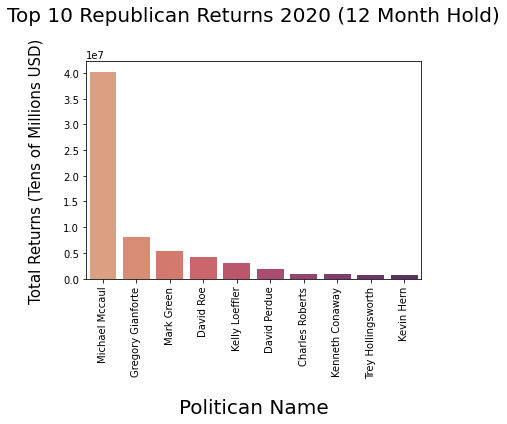

In [9]:
#graph the bar chart
palette = sns.color_palette("flare",10)
ax=sns.barplot(x=pol_df["REP_FULLNAME"],y=pol_df["NOMINAL_GAINS_2020"],palette=palette)
ax.set_xlabel("Politican Name",fontsize=20,labelpad=20)
ax.set_ylabel("Total Returns (Tens of Millions USD)",fontsize=15,labelpad=20)
ax.set_title("Top 10 Republican Returns 2020 (12 Month Hold)", fontsize=20, pad=40)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90,fontsize=10)
plt.savefig('bfb_visualization_4_TWELVE_REP_bar')